https://github.com/mljar/mljar-supervised

In [ ]:
import pandas as pd
import numpy as np
import bisect
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from supervised.automl import AutoML
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error

df = pd.read_csv('data/combined_df.csv')
train_df = df[
        (df['Year'] >= 2020) &
        (df['Headliner'].str.contains('"', na=False)) &
        (~df['Support'].isna()) &
        (df['Genre'] != 'Family Entertainment')
    ]

train_df[train_df['Genre'].apply(lambda x: ',' in x if isinstance(x, str) else False)]['Genre']

flattened_genres = [
    item.strip()
    for sublist in train_df['Genre'].apply(lambda x: x.split(',') if isinstance(x, str) else [])
    for item in sublist
]
flattened_genres = list(set(flattened_genres))

train_df.loc[:,flattened_genres] = False

for i, row in train_df.iterrows():
    if isinstance(row['Genre'], str):
        genres = [g.strip() for g in row['Genre'].split(',')]
    for genre in genres:
        train_df.at[i, genre] = True

/Users/sanggyuan/miniconda3/envs/arn/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/var/folders/wn/l975j2y549s6t035jmq4hkd80000gn/T/ipykernel_74405/3052446054.py:10: DtypeWarning: Columns (2,3,6,7,8,9,10,28) have mixed types. Specify dtype option on import or set low_memory=False.


In [ ]:
features = [
    'Avg. Event Capacity',
    'Ticket Price Min USD',
    'Ticket Price Max USD',
    'Month',
    'day_of_week',
    'Market',
    'monthly_listeners'
] + flattened_genres

X_train = train_df[features]
y_train = train_df['Avg. Gross USD']

X_train.shape

(2350, 31)

In [ ]:
automl = AutoML(
    algorithms=["CatBoost", "Xgboost", "LightGBM", "Random Forest"],
    mode="Compete",  # Available modes are Explain / Perform / Compete
    ml_task="regression",
    eval_metric='rmse',
    random_state=42,
    validation_strategy={
        "validation_type": "kfold",  # Use K-Fold cross-validation
        "k_folds": 5,  # Number of folds
        "repeats": 10,  # Number of repeats
        "shuffle": True,  # Shuffle data before splitting
        "stratify": False
    },
    total_time_limit=None,
    model_time_limit=None
)

automl.fit(X_train, y_train)

Disable stacking for repeated validation
AutoML directory: AutoML_5
The task is regression with evaluation metric rmse
AutoML will use algorithms: ['CatBoost', 'Xgboost', 'LightGBM', 'Random Forest']
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'not_so_random', 'mix_encoding', 'golden_features', 'kmeans_features', 'insert_random_feature', 'features_selection', 'hill_climbing_1', 'hill_climbing_2', 'ensemble']
Skip simple_algorithms because no parameters were generated.
* Step default_algorithms will try to check up to 4 models
1_Default_LightGBM rmse 359264.241615 trained in 61.73 seconds
2_Default_Xgboost rmse 370846.853746 trained in 25.68 seconds
3_Default_CatBoost rmse 364011.669061 trained in 26.94 seconds
4_Default_RandomForest rmse 534834.029988 trained in 43.74 seconds
* Step not_so_random will try to check up to 36 models
14_LightGBM rmse 472213.634297 trained in 42.14 seconds
5_Xgboost rmse 373100.933323 trained in 24.4 secon

AutoML(algorithms=['CatBoost', 'Xgboost', 'LightGBM', 'Random Forest'],
       eval_metric='rmse', ml_task='regression', mode='Compete',
       random_state=42, total_time_limit=None,
       validation_strategy={'k_folds': 5, 'repeats': 10, 'shuffle': True,
                            'stratify': False, 'validation_type': 'kfold'})

In [ ]:
# can check these folders for more details
print(automl.ensemble.involved_model_names())

# it creates an out of fold prediction during training
oof_pred = automl.ensemble.oof_predictions['prediction']
true = automl.ensemble.oof_predictions['target']
print('rmse:', root_mean_squared_error(true, oof_pred))
print('mae:', mean_absolute_error(true, oof_pred))
print('r_squared:', r2_score(true, oof_pred))

['Ensemble', '41_CatBoost_GoldenFeatures_SelectedFeatures', '46_LightGBM_GoldenFeatures', '60_CatBoost_GoldenFeatures_SelectedFeatures', '62_LightGBM_GoldenFeatures']
rmse: 336340.42120977555
mae: 104024.35461510636
r_squared: 0.8390626921537288


In [ ]:
# It means when combining models, model 41 was weighted 37 / (37 + 3 + 24 + 25) and so on

models_weight = [
    (k, model['repeat'])
    for model in automl.ensemble.selected_models
    for k, v in automl.ensemble.models_map.items()
    if v == model['model']
]
models_weight

[('41_CatBoost_GoldenFeatures_SelectedFeatures', 37.0),
 ('46_LightGBM_GoldenFeatures', 3.0),
 ('60_CatBoost_GoldenFeatures_SelectedFeatures', 24.0),
 ('62_LightGBM_GoldenFeatures', 25.0)]

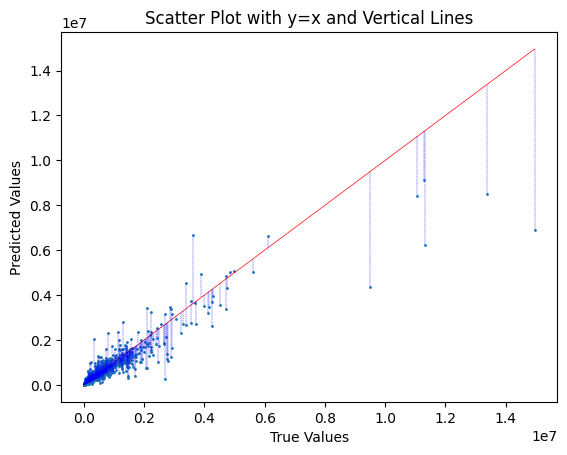

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(true, oof_pred, label="Predictions", s=1)

# Add the y=x line
plt.plot([true.min(), true.max()], [true.min(), true.max()], color="red", label="y=x", linewidth=0.5)

# Add vertical lines from each point to y=x
for t, p in zip(true, oof_pred):
    plt.plot([t, t], [t, p], color="blue", linestyle="--", linewidth=0.3)

# Labels and legend
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Scatter Plot with y=x and Vertical Lines")
plt.show()

In [ ]:
# NOTE Do not use this way to predict on the dataset
#      since it's testing on a dataset that the model was trained on

pred = automl.predict(X_train)
print('rmse:', root_mean_squared_error(y_train, pred))
print('mae:', mean_absolute_error(y_train, pred))
print('r_squared:', r2_score(y_train, pred))

rmse: 206495.5513770348
mae: 73753.44031013192
r_squared: 0.9393375419290317
